In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sys
import astropy.units as u
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda

sys.path.insert(0, '../')
from libra import Spot, Star

In [7]:
from glob import glob

paths = glob('/Users/bmmorris/git/freckles/data/lte*BT-Settl.spec.fits')

from astropy.io import fits

phoenix_wavelengths = fits.getdata(paths[0])['Wavelength']

temperatures = []
model_fluxes = []

for path in paths:
    hdu = fits.open(path)
    temperatures.append(hdu[1].header['PHXTEFF'])
    interp_flux = np.interp(wavelengths, hdu[1].data['Wavelength'], hdu[1].data['Flux'])
    model_fluxes.append(interp_flux)
    
model_fluxes = np.vstack(model_fluxes)
temperatures = np.array(temperatures)

In [87]:
V = 18.8
R = 16.6

def sort_transmittance(*args):
    sort = np.argsort(args[0])
    return lambda x: np.interp(x, args[0][sort]/1000, args[1][sort]/1000, left=0, right=0)

trans_v = sort_transmittance(*np.loadtxt('../libra/data/filters/Bessel_V-1.txt', unpack=True, delimiter='\t\t'))
trans_b = sort_transmittance(*np.loadtxt('../libra/data/filters/Bessel_B-1.txt', unpack=True, delimiter='\t\t'))
trans_r = sort_transmittance(*np.loadtxt('../libra/data/filters/Bessel_R-1.txt', unpack=True, delimiter='\t\t'))
trans_i = sort_transmittance(*np.loadtxt('../libra/data/filters/Bessel_I-1.txt', unpack=True, delimiter='\t\t'))


$$ V - R = 2.5 \log_{10} \frac{\int_V F_\lambda d\lambda}{\int_R F_\lambda d\lambda} $$

In [109]:
b_mstar, v_mstar, r_mstar, i_mstar = 0.020, 0.030, 0.039, 0.035
b_fstar, v_fstar, r_fstar, i_fstar = 6.3170e-9, 3.6186e-9, 2.1652e-9, 1.1327e-9

def vega_mag(wavelength, flux, trans, mstar, fstar):
    numerator = np.trapz(flux * wavelength * trans(wavelength), wavelength)
    denominator = np.trapz(wavelength * trans(wavelength), wavelength)
    return -2.5 * np.log10(numerator / denominator) + mstar + 2.5 * np.log10(fstar)

def flux_to_b_minus_v(wavelength, flux):
    flux_v = np.trapz(flux * trans_v(wavelength), wavelength)
    flux_b = np.trapz(flux * trans_b(wavelength), wavelength)
#     plt.plot(wavelength, flux/flux.max())
#     plt.plot(wavelength, trans_r(wavelength))
#     plt.xlim([0.1, 1])
#     plt.show()
    const = 2.5 * np.log10(np.trapz(trans_b(wavelength), wavelength) / np.trapz(trans_v(wavelength), wavelength))
    return - 2.5 * np.log10(flux_b / flux_v) #+ const

def flux_to_v_minus_r(wavelength, flux):
    flux_v = np.trapz(flux * trans_v(wavelength), wavelength)
    flux_r = np.trapz(flux * trans_r(wavelength), wavelength)
#     plt.plot(wavelength, flux/flux.max())
#     plt.plot(wavelength, trans_r(wavelength))
#     plt.xlim([0.1, 1])
#     plt.show()
    const = 2.5 * np.log10(np.trapz(trans_v(wavelength), wavelength) / np.trapz(trans_r(wavelength), wavelength))
    return - 2.5 * np.log10(flux_v / flux_r) #+ const

def flux_to_v_minus_i(wavelength, flux):
    
#     plt.plot(wavelength, flux/flux.max())
#     plt.plot(wavelength, trans_v(wavelength))
#     plt.xlim([0.1, 1])
#     plt.show()
    
    flux_v = np.trapz(flux * wavelength * trans_v(wavelength), wavelength)
    flux_i = np.trapz(flux * wavelength * trans_i(wavelength), wavelength)
    const = 2.5 * np.log10(np.trapz(trans_v(wavelength), wavelength) / np.trapz(trans_r(wavelength), wavelength))

    return - 2.5 * np.log10(flux_v / flux_i) + const

K8V: 4000 K (Mamajek)

V-R = 0.843,  V-I = 1.632

In [113]:
k8v = model_fluxes[np.argmin(np.abs(temperatures - 4000)), :]

#flux_to_b_minus_v(phoenix_wavelengths, k8v), flux_to_v_minus_r(phoenix_wavelengths, k8v), flux_to_v_minus_i(phoenix_wavelengths, k8v)
b = vega_mag(phoenix_wavelengths, k8v, trans_b, b_mstar, b_fstar)
v = vega_mag(phoenix_wavelengths, k8v, trans_v, v_mstar, v_fstar)
r = vega_mag(phoenix_wavelengths, k8v, trans_r, r_mstar, r_fstar)
i = vega_mag(phoenix_wavelengths, k8v, trans_r, r_mstar, i_fstar)

v - r, v - i

(0.70259301277640418, 1.4060508075475013)

(200, 1200)

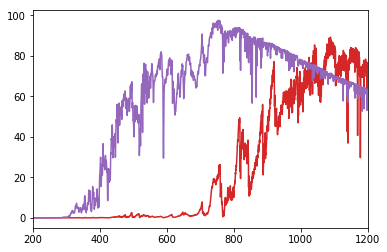

In [108]:
from scipy.ndimage import gaussian_filter1d
phoenix_2500 = model_fluxes[np.argmin(np.abs(temperatures - 2500)), :]

phoenix_3700 = model_fluxes[np.argmin(np.abs(temperatures - 4000)), :]

plt.plot(phoenix_wavelengths, trans_v(phoenix_wavelengths))
plt.plot(phoenix_wavelengths, trans_r(phoenix_wavelengths))
plt.plot(phoenix_wavelengths, trans_i(phoenix_wavelengths))

plt.plot(phoenix_wavelengths*1000, gaussian_filter1d(phoenix_2500/phoenix_2500.max() * 100, 100))

plt.plot(phoenix_wavelengths*1000, gaussian_filter1d(phoenix_3700/phoenix_3700.max() * 100, 100))

plt.xlim([200, 1200])